In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import glob

In [2]:
# Setup your PBSCluster
import dask
from dask_jobqueue import PBSCluster
from dask.distributed import Client
ncores=1
nmem='10GB'
cluster = PBSCluster(
    cores=ncores, # The number of cores you want
    memory=nmem, # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='$TMPDIR', # Use your local directory
    resource_spec='select=1:ncpus='+str(ncores)+':mem='+nmem, # Specify resources
    account='P93300641', # Input your project ID here
    walltime='03:00:00', # Amount of wall time
)

# Scale up
cluster.scale(30)

# Setup your client
client = Client(cluster)

In [3]:
from utils import *

In [4]:
#param and landarea information
df=pd.read_csv('/glade/campaign/asp/djk2120/PPEn11/csvs/lhc220926.txt',index_col=0)
params=xr.Dataset(df)
la=xr.open_dataset('../pyth/sparsegrid_landarea.nc').landarea

### NBP quantiles

In [119]:
#read in the post-processed dataset
ds=xr.concat([get_postp('transient'),get_postp('SSP370')],dim='year')

In [5]:
help(get_postp)

Help on function get_postp in module utils:

get_postp(exp)
    Fetch the post-processed PPE as an xarray dataset.
    
    Function arguments:
    exp -- one of 'transient', 'SSP126', 'SSP370'
    
    Returns:
    ds -- xarray dataset
    
    Post-processing info:
    We computed the global annual average for a small set of common data variables.



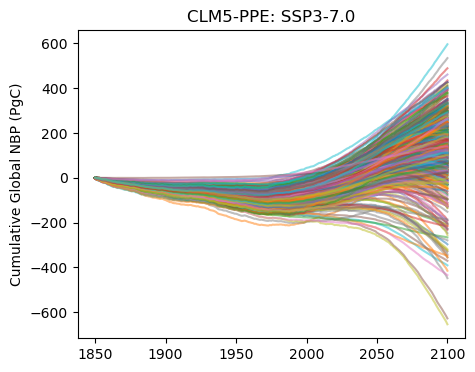

In [152]:
#spaghetti plot
cf= 24*60*60*365*1e-9*la.sum()   #gc/m2/s --> PgC/yr
plt.figure(figsize=[5,4])
plt.plot(ds.year,(cf*ds.NBP).cumsum(dim='year'),alpha=0.5);
plt.ylabel('Cumulative Global NBP (PgC)')
plt.title('CLM5-PPE: SSP3-7.0');

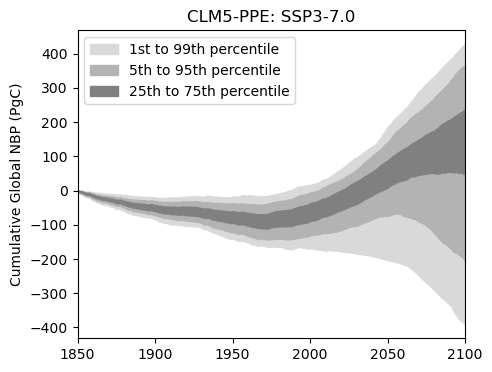

In [153]:
#quantile shading
v='NBP'
cf= 24*60*60*365*1e-9*la.sum()   #gc/m2/s --> PgC/yr
qqs=[1,5,25]
grays=[0.85,0.7,0.5]

plt.figure(figsize=[5,4])
for qq,gray in zip(qqs,grays):
    label=ord(qq)+' to '+ord(100-qq)+' percentile'
    x=cf*ds[v].cumsum(dim='year').quantile([qq/100,1-qq/100],dim='ens')
    plt.fill_between(x.year,x.isel(quantile=0),x.isel(quantile=1),
                     color=gray*np.ones(3),label=label)
plt.legend(loc=2);
plt.xlim([1850,2100])
plt.ylabel('Cumulative Global NBP (PgC)')
plt.title('CLM5-PPE: SSP3-7.0');

In [498]:
def hist_plot(data,constrainer,cflag,ylabel,clabel,title,
              ylim=None,xlim=[2020,2100],rounding=0):
    fig,axs=plt.subplot_mosaic('AB',
                           figsize=[8,4],
                           gridspec_kw={'width_ratios': [3,1]},
                           layout='constrained')
    colors,edges,mids,vmin,vmax=colorkey(constrainer,8)
    for n,c in zip(data.isel(ens=cflag).T,np.array(colors)[cflag,:]):
        axs['A'].plot(n.year,n,color=c)
    axs['A'].set_xlim(xlim);
    axs['A'].set_ylabel(ylabel)
    axs['A'].set_title(title);
    axs['A'].set_xlabel('Year')
    if ylim:
        axs['A'].set_ylim(ylim)
    else:
        ylim=axs['A'].get_ylim()
    
    axin1 = axs['A'].inset_axes([0.05, 0.1, 0.6, 0.1])
    axin1.pcolormesh(edges,[0,1],mids.T)
    axin1.set_yticks([]);
    axin1.set_title(clabel,fontsize=10)
    
    axs['B'].hist(data.isel(ens=cflag,year=-1),orientation="horizontal",color=0.7*np.ones(3))
    axs['B'].set_ylim(axs['A'].get_ylim());
    axs['B'].set_yticklabels([])
    axs['B'].set_xlabel('nEns');

    qq=data.isel(ens=cflag,year=-1).quantile([0.05,0.95]).values
    dq=np.round(qq[1]-qq[0],rounding)
    avg=np.round(data.isel(ens=cflag,year=-1).mean().values,rounding)

    if rounding==0:
        avg=int(avg)
        dq=int(dq)

    yloc1=ylim[0]+0.15*(ylim[1]-ylim[0])
    yloc2=ylim[0]+0.1*(ylim[1]-ylim[0])
    u=ylabel.split('(')[1].split(')')[0]
    axs['B'].text(0,yloc1,'  average: '+str(avg)+' '+u)
    axs['B'].text(0,yloc2,'  spread: '+str(dq)+' '+u)
    
    return ylim

### test average LAI as NBP constraint
 - spoiler: it's not great!

In [480]:
lai=ds.TLAI.sel(year=slice(2005,2014)).mean(dim='year').compute()
nbp=cf*ds.NBP.sel(year=slice(2020,2100)).cumsum(dim='year').compute()

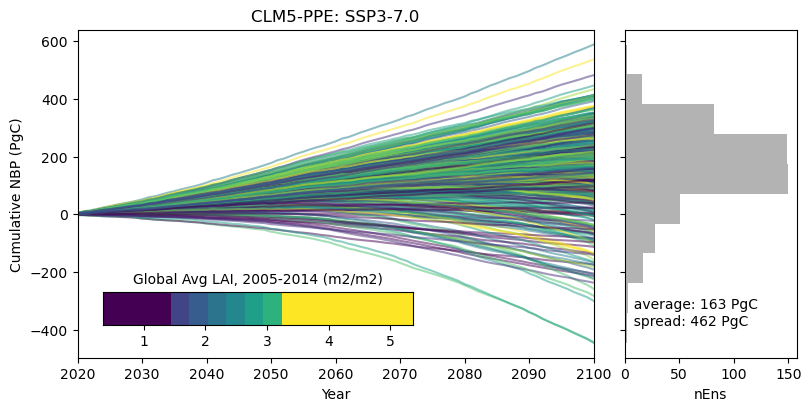

In [499]:
ylabel='Cumulative NBP (PgC)'
clabel='Global Avg LAI, 2005-2014 (m2/m2)'
title='CLM5-PPE: SSP3-7.0'
cflag=lai>-np.inf
ylim=hist_plot(nbp,lai,cflag,ylabel,clabel,title)

<xarray.DataArray 'TLAI' ()>
array(158)


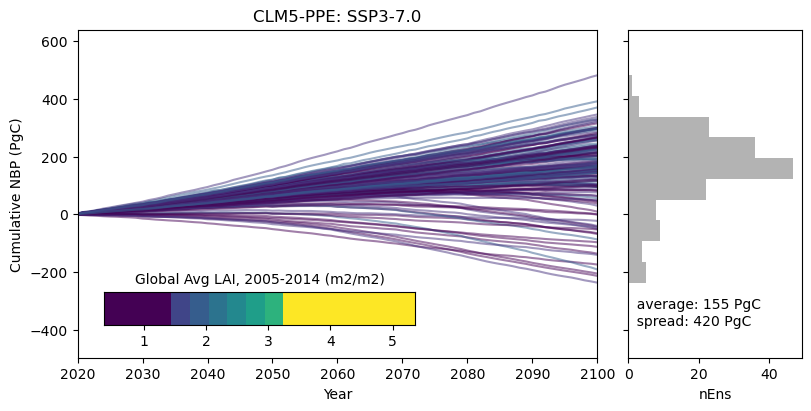

In [501]:
cflag=(lai>1)&(lai<2)
hist_plot(nbp,lai,cflag,ylabel,clabel,title,ylim=ylim);
print(cflag.sum())

### historical NBP would be a much better constraint
 - but do we actually know what that value has been?

In [486]:
#examine the influence of an alternative constraint
nbp0=cf*ds.NBP.sel(year=slice(2005,2014)).mean(dim='year').compute()
nbp=cf*ds.NBP.sel(year=slice(2020,2100)).cumsum(dim='year').compute()

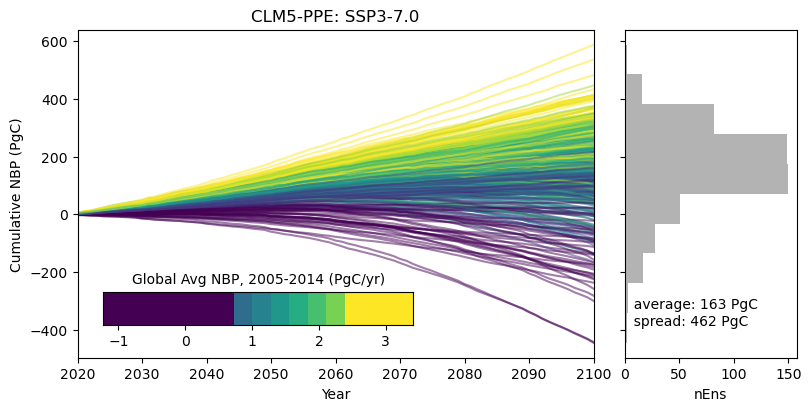

In [502]:
ylabel='Cumulative NBP (PgC)'
clabel='Global Avg NBP, 2005-2014 (PgC/yr)'
cflag=nbp0>-np.inf
ylim=hist_plot(nbp,nbp0,cflag,ylabel,clabel,title)

<xarray.DataArray ()>
array(278)


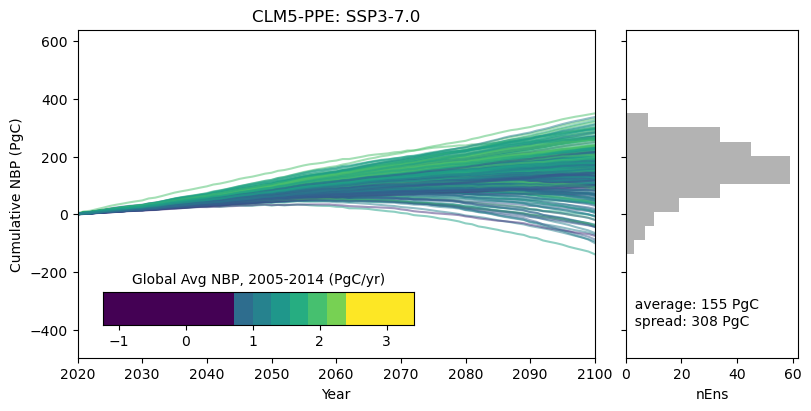

In [505]:
ylabel='Cumulative NBP (PgC)'
clabel='Global Avg NBP, 2005-2014 (PgC/yr)'
cflag=(nbp0>1)&(nbp0<2)
print(cflag.sum())
hist_plot(nbp,nbp0,cflag,ylabel,clabel,title,ylim=ylim);

### examine a bunch of constraints

In [515]:
years=slice(1995,2014)
carbons=['GPP','AR','HR','COL_FIRE_CLOSS','NPP','NEP','NBP']
cfs={v:24*60*60*365*1e-9*la.sum() for v in carbons}
cfs['TLAI']=1
arrays={v:cfs[v]*ds[v].sel(year=years).mean(dim='year').compute() for v in cfs}
for v in cfs:
    arrays[v+'_trend']=(cfs[v]*ds[v]).sel(year=years).polyfit(dim='year',deg=1).polyfit_coefficients.sel(degree=1).compute()

In [521]:
nbp370=cfs['NBP']*ds.NBP.sel(year=slice(2020,2100)).sum(dim='year')

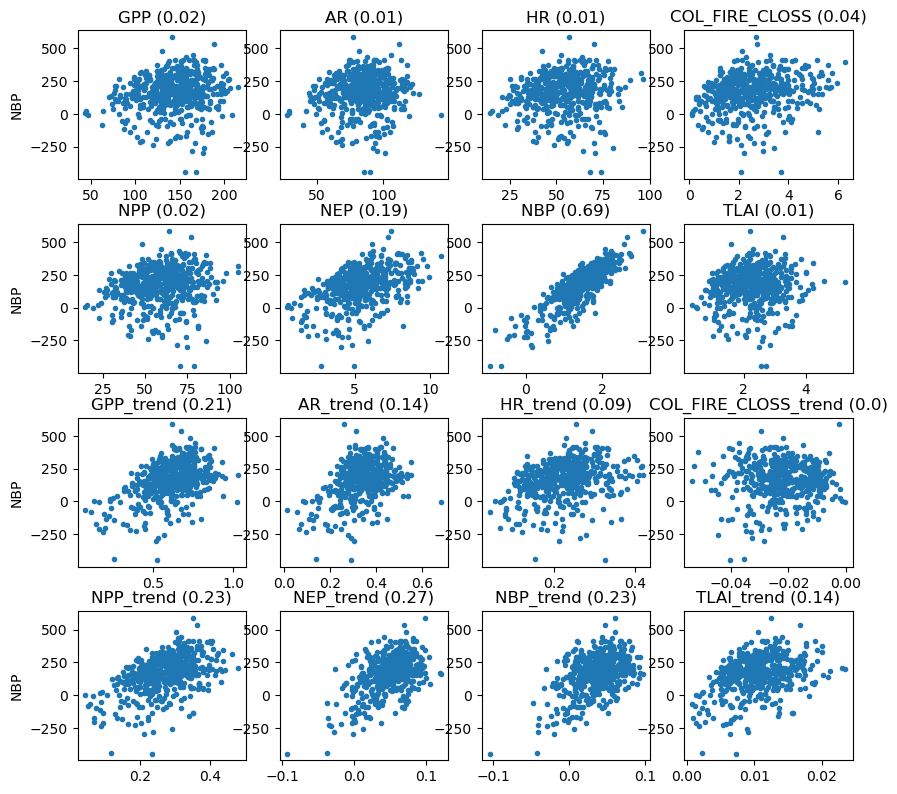

In [524]:
plt.figure(figsize=[10,12])
for i,v in enumerate(arrays):
    plt.subplot(5,4,i+1)
    plt.plot(arrays[v],nbp370,'.')
    
    r2=np.round(np.corrcoef(arrays[v],nbp370)[0,1]**2,2)
    plt.title(v+' ('+str(r2)+')')
    if i%4==0:
        plt.ylabel('NBP')

plt.subplots_adjust(hspace=0.3)

In [526]:
import statsmodels.api as sm

In [530]:
#combine constraints in multi-linear model
dvs=['TLAI','TLAI_trend']
x=np.ones([500,len(dvs)+1])
for i,v in enumerate(dvs):
    x[:,i+1]=arrays[v]
lm=sm.OLS(nbp370.values,x).fit()
lm.rsquared

0.3944275050391455

### if you want to look at the original (non-postp data)

In [532]:
help(get_exp)

Help on function get_exp in module utils:

get_exp(exp, dvs, yr0, yr1, tape='h0')
    Retrieve a subsetted dataset for the chosen experiment.
    
    Function arguments:
    exp -- one of 'transient', 'SSP126', 'SSP370'
    dvs -- data variables, e.g. ['TLAI','GPP']
    yr0/yr1 -- time range, inclusive
    tape -- history tape, one of 'h0', 'h1', 'h5'
    
    Returns:
    ds -- xarray dataset



In [78]:
dvs=['NBP','TLAI','GPP','HR','EFLX_LH_TOT','SOILWATER_10CM']
yr0,yr1=(2005,2014)
ds=get_exp('transient',dvs,yr0,yr1)

In [10]:
lai=amean(ds.TLAI).mean(dim='year')

In [13]:
ens_avg=lai.isel(member=range(1,501)).mean(dim='member')
clm5_def=lai.isel(member=0)

In [14]:
def get_map(da,sgmap=None):
    if not sgmap:
        sgmap=xr.open_dataset('/glade/u/home/djk2120/ppe_clean/pyth/sgmap.nc')
    return da.sel(gridcell=sgmap.cclass).where(sgmap.notnan).compute()

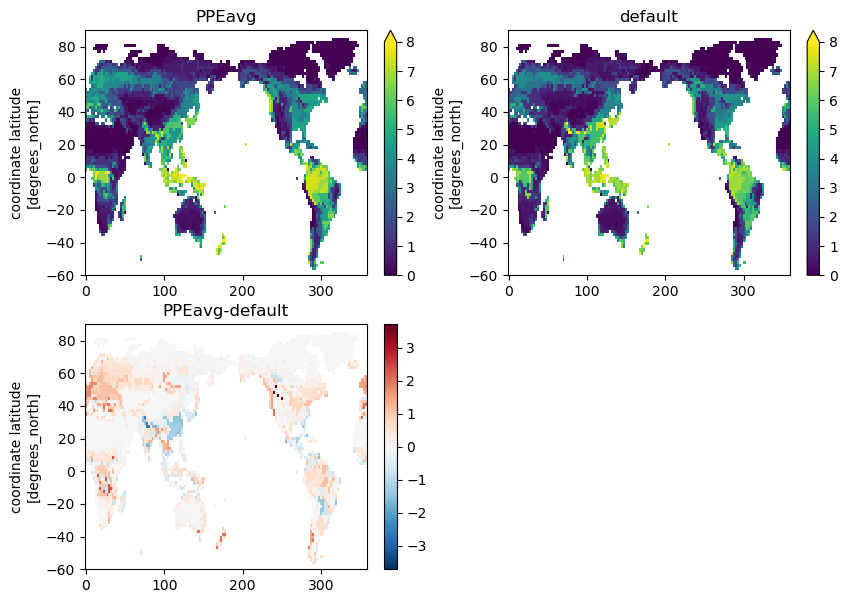

In [27]:
plt.figure(figsize=[10,7])
titles=['PPEavg','default','PPEavg-default']
for i,x in enumerate([ens_avg,clm5_def,ens_avg-clm5_def]):
    plt.subplot(221+i)
    if i<2:
        get_map(x).plot(vmin=0,vmax=8)
    else:
        get_map(x).plot()
    plt.xlabel('')
    plt.ylim([-60,90])
    plt.title(titles[i])

In [ ]:
# we have several regional averaging functions...
# gmean .. global mean
# bmean .. biome mean
# pmean .. pft mean (needs h1 data in the ds)


In [28]:
def bmean(da,la,biome):
    x=1/la.groupby(biome).sum()*(da*la).groupby(biome).sum()
    return x.compute()

In [44]:
whit=xr.open_dataset('/glade/u/home/djk2120/ppe_clean/pyth/whit/whitkey.nc')

In [34]:
cf=24*60*60*365*1e-9*la.sum()
nbp=cf*gmean(amean(ds.NBP).mean(dim='year'),la)

In [49]:
cf=24*60*60*365*1e-9*la.groupby(whit.biome).sum()
gpp_ann=amean(ds.GPP).mean(dim='year')
gpp_ann_biome=cf*bmean(gpp_ann,la,whit.biome)

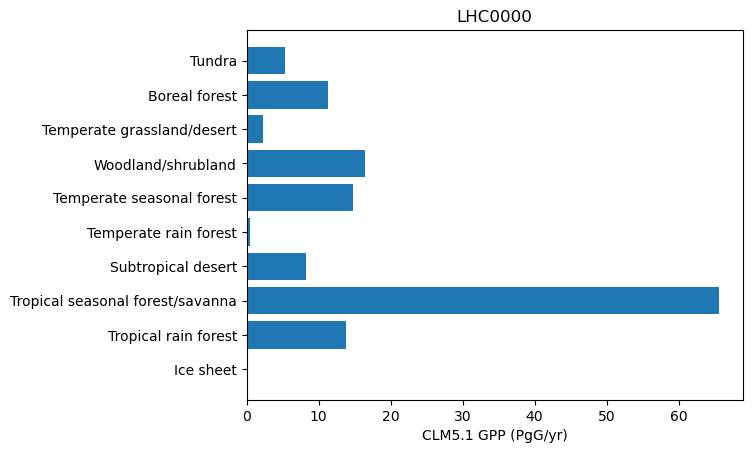

In [61]:
mem='LHC0000' #CLM5.1 default paramset
plt.barh(range(10),gpp_ann_biome.sel(member=mem))
plt.yticks(range(10),whit.biome_name.values);
plt.xlabel('CLM5.1 GPP (PgG/yr)');
plt.title(mem);

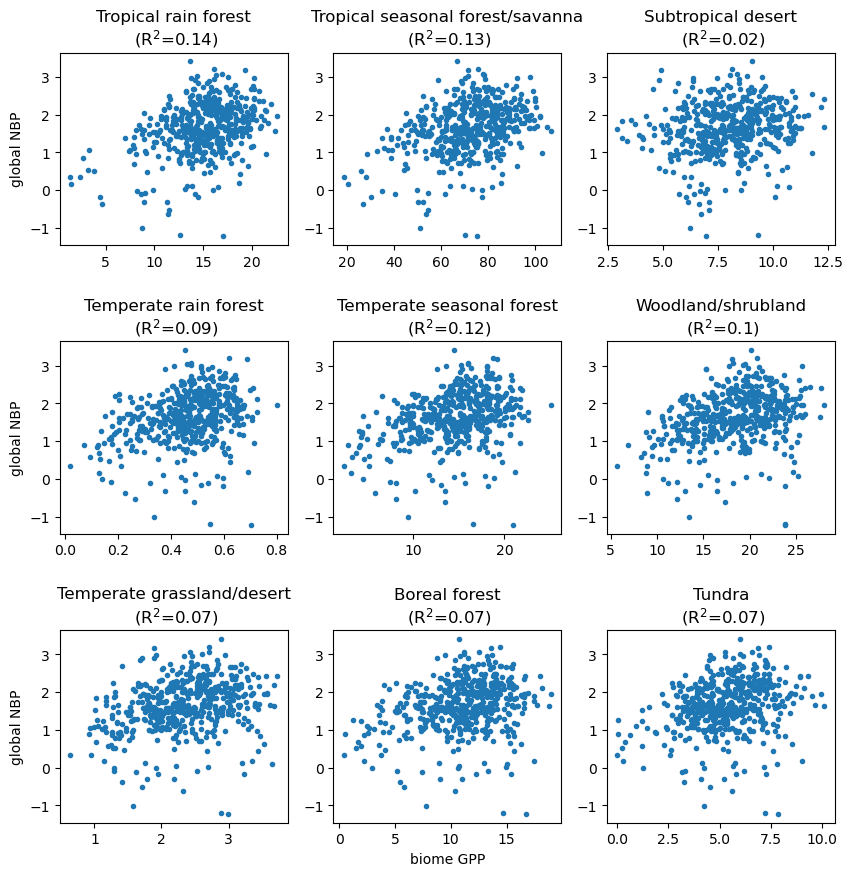

In [77]:
plt.figure(figsize=[10,10])
for b in range(1,10):
    plt.subplot(3,3,b)
    plt.plot(gpp_ann_biome.isel(biome=b),nbp,'.')
    r2=np.round(np.corrcoef(gpp_ann_biome.isel(biome=b),nbp)[0,1]**2,2)
    plt.title(str(whit.biome_name.isel(biome_id=b).values)+'\n (R$^2$='+str(r2)+')')
    
    if b==8:
        plt.xlabel('biome GPP')
    if b%3==1:
        plt.ylabel('global NBP')

plt.subplots_adjust(hspace=0.5)

In [79]:
cf=24*60*60*365*1e-9*la.groupby(whit.biome).sum()
hr_ann=amean(ds.HR).mean(dim='year')
hr_ann_biome=cf*bmean(hr_ann,la,whit.biome)

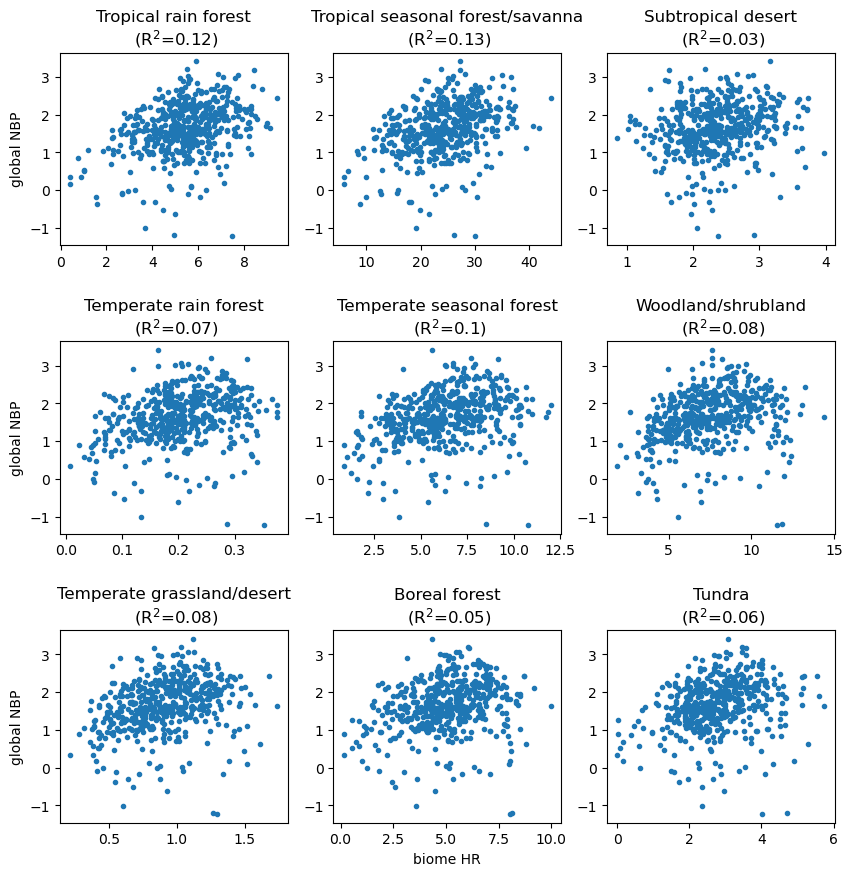

In [80]:
plt.figure(figsize=[10,10])
for b in range(1,10):
    plt.subplot(3,3,b)
    plt.plot(hr_ann_biome.isel(biome=b),nbp,'.')
    r2=np.round(np.corrcoef(hr_ann_biome.isel(biome=b),nbp)[0,1]**2,2)
    plt.title(str(whit.biome_name.isel(biome_id=b).values)+'\n (R$^2$='+str(r2)+')')
    
    if b==8:
        plt.xlabel('biome HR')
    if b%3==1:
        plt.ylabel('global NBP')

plt.subplots_adjust(hspace=0.5)

In [81]:
cf=24*60*60*365*1e-9*la.groupby(whit.biome).sum()
nbp_ann=amean(ds.NBP).mean(dim='year')
nbp_ann_biome=cf*bmean(nbp_ann,la,whit.biome)

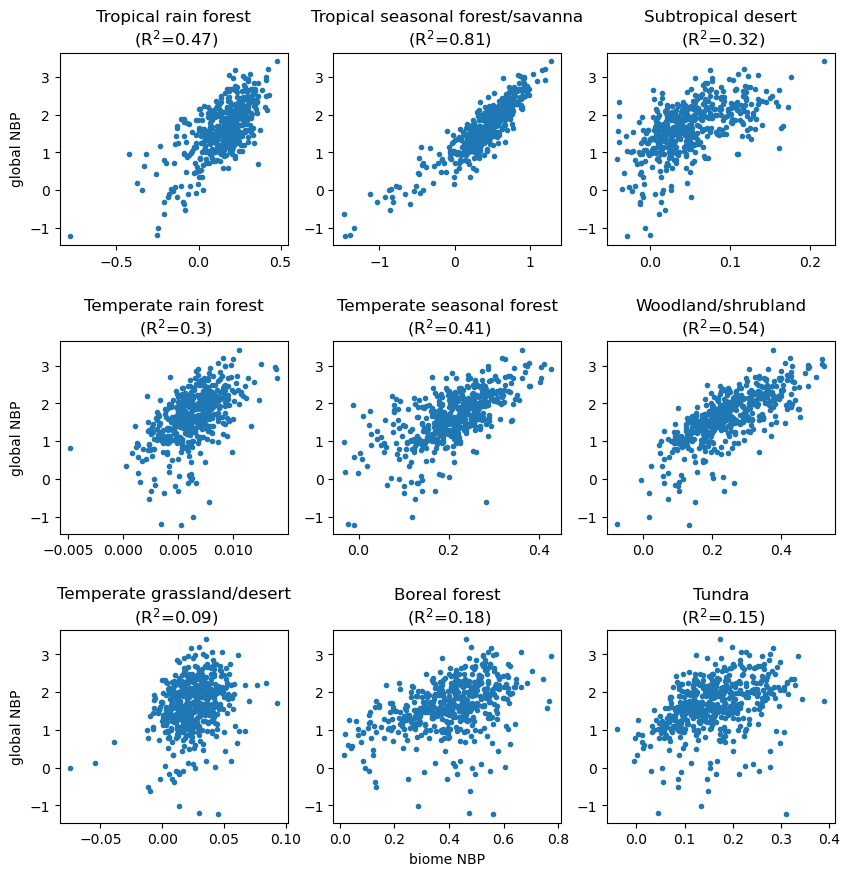

In [82]:
plt.figure(figsize=[10,10])
for b in range(1,10):
    plt.subplot(3,3,b)
    plt.plot(nbp_ann_biome.isel(biome=b),nbp,'.')
    r2=np.round(np.corrcoef(nbp_ann_biome.isel(biome=b),nbp)[0,1]**2,2)
    plt.title(str(whit.biome_name.isel(biome_id=b).values)+'\n (R$^2$='+str(r2)+')')
    
    if b==8:
        plt.xlabel('biome NBP')
    if b%3==1:
        plt.ylabel('global NBP')

plt.subplots_adjust(hspace=0.5)

### pft-level data

In [74]:
lapft=xr.open_dataset('/glade/u/home/djk2120/ppe_clean/pyth/landarea_transient.nc',chunks={'time':30}).landarea_pft
pfile=xr.open_dataset('/glade/campaign/asp/djk2120/PPEn11/paramfiles/LHC0000.nc')
pftnames=[str(p)[2:-1].strip() for p in pfile.pftname[:17].values]

In [59]:
ds=get_exp('transient',['TLAI','GPP'],2005,2014,tape='h1')

In [107]:
mem='LHC0000' #default
da=ds.GPP.sel(member=mem)
cf=24*60*60*365*1e-9*lapft.groupby('pft').sum().compute()
gpp=amean(cf*pmean(da,lapft)).mean(dim='year')

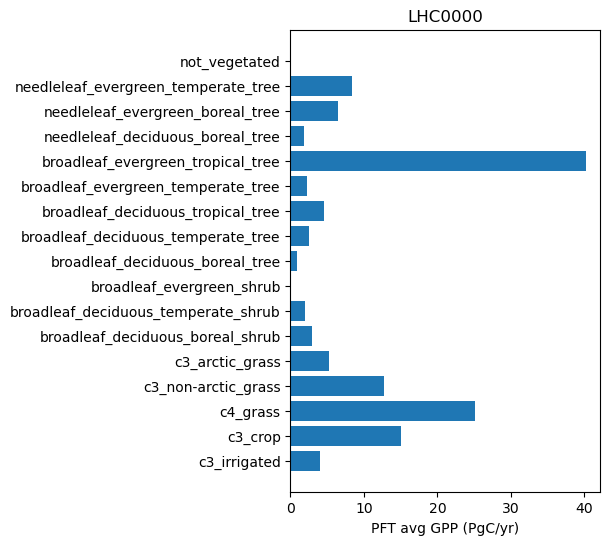

In [110]:
plt.figure(figsize=[4,6])
plt.barh(range(17),gpp)
plt.yticks(range(17),pftnames)
plt.gca().invert_yaxis()
plt.xlabel('PFT avg GPP (PgC/yr)')
plt.title(mem);